# 01 Prepare scenarios

In [1]:
import os
from pathlib import Path

import pandas as pd
import pyam
import dotenv
import silicone.time_projectors as timeproj

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

Step 1: Read in the 2024 update to the Global Carbon Project.

In [2]:
dotenv.load_dotenv()

True

In [3]:
gcp_data = pd.read_excel(
    Path(
        os.environ['GCP']
    ),
    sheet_name='Territorial Emissions',
    skiprows=11,
    index_col=0
)

Step 2: Process and case to a pyam dataframe

In [4]:
hist_data = pyam.IamDataFrame(
    pd.DataFrame(gcp_data['World'])
    .T
    .reset_index()
    .rename(
        columns={'index':'region'}
    )
    .assign(
        model='GCP',
        scenario='hist',
        variable='Emissions|CO2|Energy and Industrial Processes',
        unit='Mt C/yr'
    )
)

In [5]:
hist_data.convert_unit(
    current='Mt C/yr',
    to='Gt CO2/yr',
    inplace=True
)

Step 3: We now want to construct three diagnostic experiments:
1. Last historical year to 0 by 2050
2. Flat emissions from last historical year to 2030 or 2040 and then to 0 by 2050

In [6]:
project2050 = timeproj.LinearExtender()
netzero2050 = project2050.derive_relationship(
    variable='Emissions|CO2|Energy and Industrial Processes',
    times=list(range(2024, 2051)),
    year_value=(2050, 0)
)(hist_data)
resultcaseone = pyam.concat([hist_data, netzero2050])

In [7]:
resultcaseone.rename(
    scenario={'hist':'hist-netzero2050'},
    inplace=True
)

<Axes: title={'center': 'model: GCP - scenario: hist-netzero2050 - region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Gt CO2/yr'>

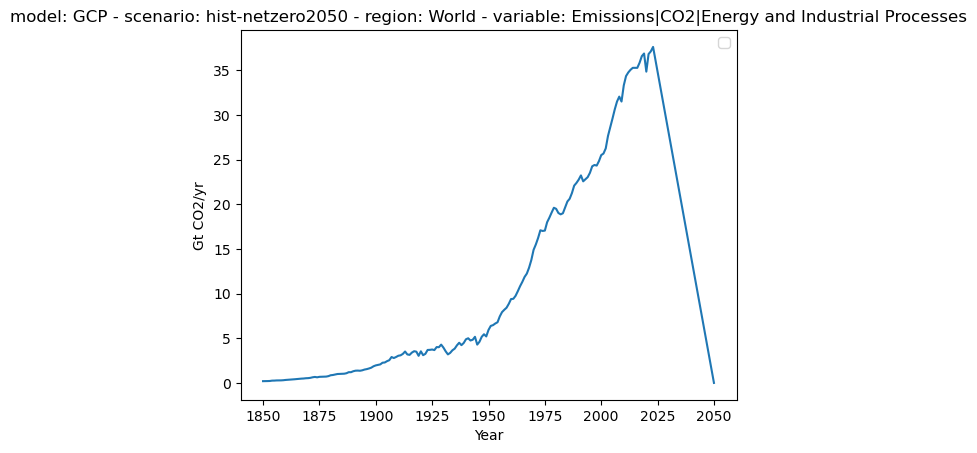

In [8]:
resultcaseone.plot()

In [9]:
constproj = timeproj.LinearExtender()
project2030 = constproj.derive_relationship(variable="Emissions|CO2|Energy and Industrial Processes", times=range(2024,2031), gradient=0)(hist_data)
project2035 = constproj.derive_relationship(variable="Emissions|CO2|Energy and Industrial Processes", times=range(2024,2036), gradient=0)(hist_data)
project2040 = constproj.derive_relationship(variable="Emissions|CO2|Energy and Industrial Processes", times=range(2024,2041), gradient=0)(hist_data)

In [10]:
resultcasetwo = pyam.concat(
    [
        hist_data,
        project2030,
        project2050.derive_relationship(
            variable="Emissions|CO2|Energy and Industrial Processes",
            times=list(range(2031, 2051)),
            year_value=(2050, 0)
        )(project2030)
    ]
)

In [11]:
resultcasetwo.rename(
    scenario={
        "hist":"hist-flat2030-netzero2050"
    },
    inplace=True
)

In [12]:
resultcasethree = pyam.concat(
    [
        hist_data,
        project2035,
        project2050.derive_relationship(
            variable="Emissions|CO2|Energy and Industrial Processes",
            times=list(range(2036, 2051)),
            year_value=(2050, 0)
        )(project2035)
    ]
)

In [13]:
resultcasethree.rename(
    scenario={
        "hist":"hist-flat2035-netzero2050"
    },
    inplace=True
)

In [14]:
resultcasefour = pyam.concat(
    [
        hist_data,
        project2040,
        project2050.derive_relationship(
            variable="Emissions|CO2|Energy and Industrial Processes",
            times=list(range(2041, 2051)),
            year_value=(2050, 0)
        )(project2040)
    ]
)

In [15]:
resultcasefour.rename(
    scenario={
        "hist":"hist-flat2040-netzero2050"
    },
    inplace=True
)

In [16]:
compiled_scenarios_co2ffi = pyam.concat(
    [
        resultcaseone,
        resultcasetwo,
        resultcasethree,
        resultcasefour
    ]
)

<Axes: title={'center': 'model: GCP - region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Gt CO2/yr'>

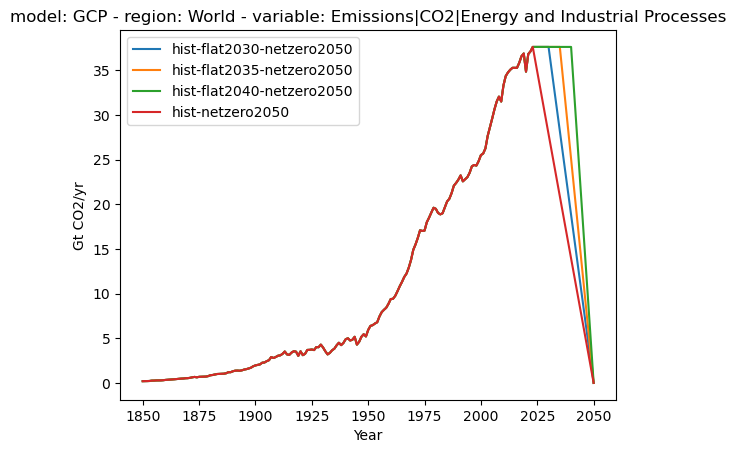

In [17]:
compiled_scenarios_co2ffi.plot()

In [18]:
results2100 = (
    constproj
    .derive_relationship(variable="Emissions|CO2|Energy and Industrial Processes", times=range(2051,2101), gradient=0)
    (compiled_scenarios_co2ffi)
)

In [19]:
compiled_scenarios_co2ffi = pyam.concat(
    [
        compiled_scenarios_co2ffi,
        results2100
    ]
)

<Axes: title={'center': 'model: GCP - region: World - variable: Emissions|CO2|Energy and Industrial Processes'}, xlabel='Year', ylabel='Gt CO2/yr'>

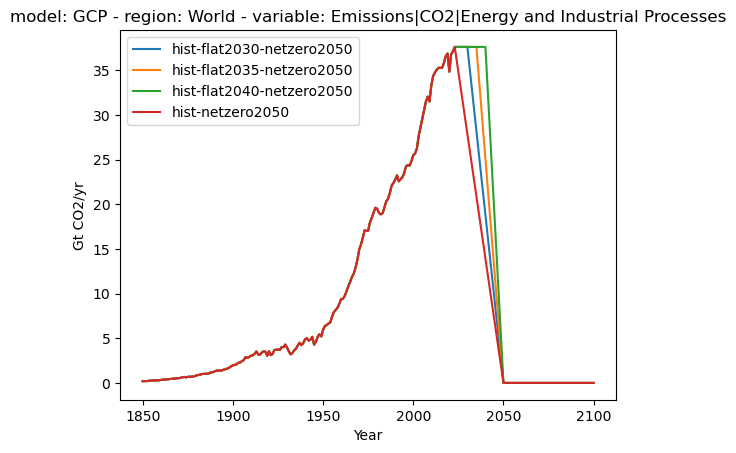

In [20]:
compiled_scenarios_co2ffi.plot()